In [371]:
!pip install torchvision
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [372]:
!pip install snntorch pandas


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip -q install matplotlib
!pip -q install tonic


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import tonic
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
height = 28
width = 28
batch_size = 128 # what does this effect
data_path = '/tmp/data/mnist'
dtype = torch.float

In [375]:
accuracy_list=[]
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    accuracy_list.append(acc)
    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [376]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
transform = transforms.Compose([
            transforms.Resize((height, width)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])
# what size was the data before?

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)


In [377]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [378]:
num_inputs = height * width
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
# experiment setting these to different values
num_steps = 25
beta = 0.95

# why layers and not individual neurons

In [379]:
# train_batch = iter(train_loader)
# meta_counter = 0
# for data, targets in train_batch:
#     print(data.view(batch_size,-1))
#     print(data.view(batch_size,-1).size())
#     print(data.size())
#     counter = 0
#     # data is [128,1,28,28]
#     # 128 28 by 28 images 
#     # targets is a list of numeric labels
#     print('target size', targets.size(), targets)
#     for i in data:
#         print(i.size())
#         counter += 1
#         # i[0] is image
#         # i is [i[0]]
#         # plt.figure()
#         # plt.imshow(i[0])
#         if counter > 5:
#             break
#     meta_counter += 1
#     break


# define training class

In [380]:
class Net(nn.Module):
    def __init__(self):
        print("INIT WAS CALLED")
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)
    
    def forward(self, x):
        # print(x.size())
        # arr = []
        # temp = []
        # for num, ele in enumerate(x[0]):
        #     if num != 0 and num % 28 == 0:
        #         arr.append(temp)
        #         temp = []
        #     temp.append(ele)
        # plt.figure()
        # plt.imshow(arr)
        # x is 128 images, whose dimensions have been flattened to 1D (784 = 28*24)
        # print("FORWARD WAS CALLED, returns memory & spike")
        mem1 = self.lif1.init_leaky() # initialize hidden states
        # must have to do this for each leaky neuron
        mem2 = self.lif2.init_leaky()
        spk2_rec = []
        mem2_rec = []
        for step in range(time_steps):
            cur1 = self.fc1(x)
            # 128 x 1000 128 images, 1D stretched ig (1000 ???)
            # it's passing the same value at every time step
            # this is what it meant by rate encoding i think
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            # a single pass through
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            # spk2_rec_np = torch.tensor([[t.item() for t in row] for row in spk2_rec])
            # spk2_rec = 25 x 128 x 10 ... what is the 10??
            # oh like what output neuron spiked... interesting ...
            # print('membrane potential size', np.array(mem2_rec).size())
        # print(spk2_rec[0][0], spk2_rec[0][1],spk2_rec[1][0])

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
net = Net().to(device) # cuda probably not available

INIT WAS CALLED


In [381]:
loss = nn.CrossEntropyLoss()
temporal_loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))


# training

In [382]:
# num_epochs = 1
# loss_hist = []
# test_loss_hist = []
# counter = 0

# # Outer training loop
# for epoch in range(num_epochs):
#     iter_counter = 0
#     train_batch = iter(train_loader)

#     # Minibatch training loop
#     for data, targets in train_batch:
#         # data is 128x1x28x28
#         # targets is 128
#         data = data.to(device)
#         targets = targets.to(device)

#         # sets training mode
#         net.train()
#         # forward pass
#         spk_rec, mem_rec = net(data.view(batch_size, -1)) # data.view = 128x784

#         # initialize the loss & sum over time
#         loss_val = torch.zeros((1), dtype=dtype, device=device)
#         for step in range(time_steps): # for each time step calculate loss
#             # inside the forward pass, each membrane potential is saved @ step index
#             # mem_rec & spk_rec are 25 x 128 x 10
#             # 10 output neurons, must be membrane potential of output neurons...
#             # what is like the threshold here
#             # what should be the target?
#             # if it's arranged T x B x output neurons
#             temporal_threshold = 0
#             if step < temporal_threshold:
#                 target_zeros = torch.zeros_like(spk_rec[step])
#                 loss_val += temporal_loss(spk_rec[step], target_zeros)
#                 """
#                 have to pass target spike times
#                 create an array with the spike times & the target spikes times
#                 for each time step ?
#                 so for each time step, there are 128 images, and each image has 10 output neurons
#                 so like maybe we pass 128 x 10 of 0s for the first 2 time_steps or something
#                 """
#             loss_val += loss(mem_rec[step], targets)
#         # if counter % 5 == 0:
#         #     print(mem_rec.size())
#         #     for i in range(len(spk_rec[0])):
#         #         if i < 5:
#         #             print(spk_rec[0][i])
#         #             print(targets[i])

#         # Gradient calculation + weight update
#         optimizer.zero_grad()
#         loss_val.backward()
#         optimizer.step()

#         # Store loss history for future plotting
#         loss_hist.append(loss_val.item())

#         # Test set
#         with torch.no_grad():
#             net.eval()
#             test_data, test_targets = next(iter(test_loader))
#             test_data = test_data.to(device)
#             test_targets = test_targets.to(device)

#             # Test set forward pass
#             test_spk, test_mem = net(test_data.view(batch_size, -1))

#             # Test set loss
#             test_loss = torch.zeros((1), dtype=dtype, device=device)
#             for step in range(time_steps):
#                 test_loss += loss(test_mem[step], test_targets)
#             test_loss_hist.append(test_loss.item())

#             # Print train/test loss/accuracy
#             if counter % 50 == 0:
#                 train_printer()
#             counter += 1
#             iter_counter +=1

In [ ]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            target_zeros = torch.zeros_like(spk_rec[step])
            temporal_threshold = 7
            if step < temporal_threshold:
                target_zeros = torch.zeros_like(spk_rec[step])
                loss_val += temporal_loss(spk_rec[step], target_zeros)
                
        loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1


Epoch 0, Iteration 0
Train Set Loss: 61.34
Test Set Loss: 54.11
Train set accuracy for a single minibatch: 48.44%
Test set accuracy for a single minibatch: 34.38%


Epoch 0, Iteration 50
Train Set Loss: 17.83
Test Set Loss: 9.94
Train set accuracy for a single minibatch: 91.41%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 100
Train Set Loss: 11.63
Test Set Loss: 11.27
Train set accuracy for a single minibatch: 89.06%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 150
Train Set Loss: 15.59
Test Set Loss: 9.34
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 200
Train Set Loss: 12.86
Test Set Loss: 6.36
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 250
Train Set Loss: 12.51
Test Set Loss: 4.84
Train set accuracy for a single minibatch: 94.53%
Test set accuracy for a single minibatch: 95.31%


Epoch

<Figure size 1000x500 with 0 Axes>

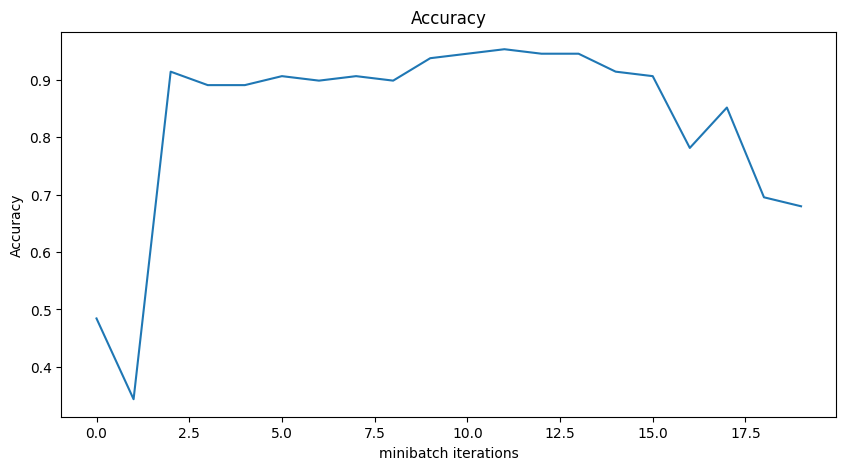

In [384]:
plt.figure(figsize=(10, 5))
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(accuracy_list)
plt.title('Accuracy')
plt.xlabel('minibatch iterations')
plt.ylabel('Accuracy')
plt.show()

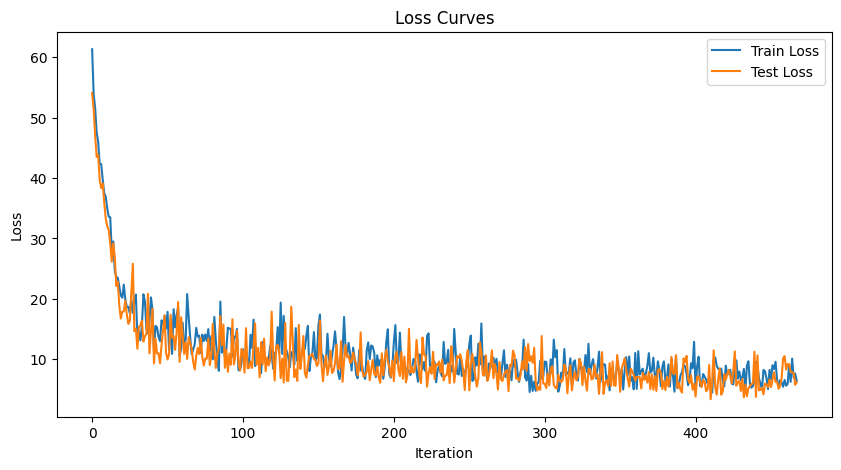

In [385]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()